In [1]:
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv
import tensorflow as tf
import scanpy as sc
import numpy as np
import anndata as ad
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
print ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

(Running UniTVelo 0.2.5.2)
2023-02-07 03:37:07
Num GPUs Available:  1


In [2]:
DATA_DIR = "../../data/HSPC"

In [4]:
tf.keras.utils.set_random_seed(0)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

In [5]:
velo_config = utv.config.Configuration()
velo_config.R2_ADJUST = True
velo_config.IROOT = None
velo_config.FIT_OPTION = '1'
velo_config.AGENES_R2 = 1
label = 'original_clusters'

------> Manully Specified Parameters <------
------> Model Configuration Settings <------
N_TOP_GENES:	2000
LEARNING_RATE:	0.01
FIT_OPTION:	1
DENSITY:	SVD
REORDER_CELL:	Soft_Reorder
AGGREGATE_T:	True
R2_ADJUST:	True
GENE_PRIOR:	None
VGENES:	basic
IROOT:	None
--------------------------------------------

Extracted 2000 highly variable genes.
Computing moments for 2000 genes with n_neighbors: 30 and n_pcs: 30

# of velocity genes 1141 (Criterion: positive regression coefficient between un/spliced counts)
# of velocity genes 1008 (Criterion: std of un/spliced reads should be moderate, w/o extreme values)
# of velocity genes 1003 (Criterion: genes have reads in more than 5% of total cells)
Using GPU card: 0


Loss (Total): 19461.250, (Spliced): 10988.501, (Unspliced): 8472.749: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11998/12000 [06:39<00:00, 27.66it/s]

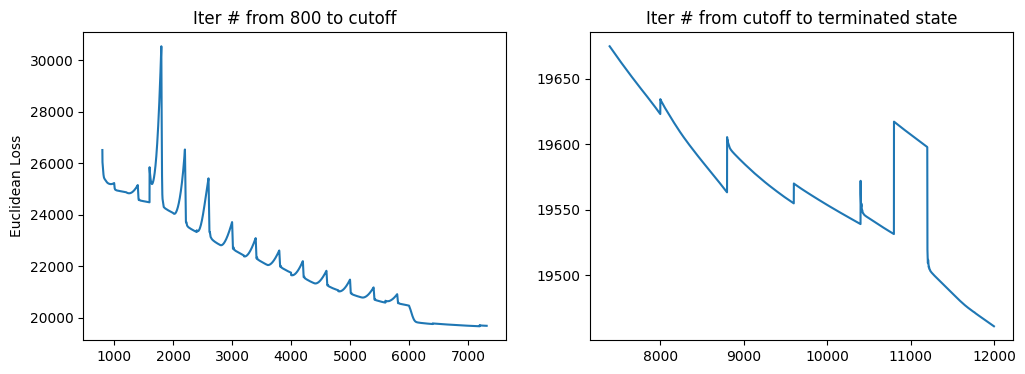

Loss (Total): 19461.250, (Spliced): 10988.501, (Unspliced): 8472.749: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 11999/12000 [06:56<00:00, 28.84it/s]

Total loss 19461.250, vgene loss 19461.250


  0%|          | 0/2430 [00:00<?, ?cells/s]

In [6]:
adata = utv.run_model(os.path.join(DATA_DIR, 'anndata_raw.h5ad'), label, config_file=velo_config)

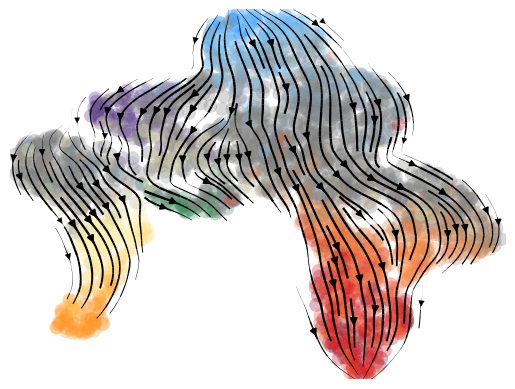

In [7]:
adata.uns["celltypes_colors"] = pd.read_csv(os.path.join(DATA_DIR, "celltypes_colors.csv"), header=None).iloc[:,0].values
adata.obsm["X_umap"] = pd.read_csv(os.path.join(DATA_DIR, "UMAP_coordinates.csv"), header = 0, index_col = 0).values
adata.obsm["X_umap_original"] = pd.read_csv(os.path.join(DATA_DIR, "original_UMAP.csv"), header = None).values
scv.pl.velocity_embedding_stream(adata, color=adata.uns['celltypes_colors'], dpi=100, title='', basis = "X_umap", colorbar = False)

In [244]:
# adata.obsp['T_fwd'] = scv.utils.get_transition_matrix(adata).astype(np.float64)
# adata.obsp['T_fwd'] /= adata.obsp["T_fwd"].sum(-1)
# adata.obsp['T_fwd'] = sp.sparse.csr_matrix(adata.obsp["T_fwd"])
import cellrank as cr
# cr.tl.transition_matrix(adata, weight_connectivities = 0.05, scheme = "cosine")
k = cr.tl.kernels.VelocityKernel(adata, scheme = 'cosine').compute_transition_matrix(softmax_scale = None)
adata.obsp["T_fwd"] = k.transition_matrix;

  0%|          | 0/2430 [00:00<?, ?cell/s]

  0%|          | 0/2430 [00:00<?, ?cell/s]

In [245]:
df = pd.read_csv(os.path.join(DATA_DIR, "Mus_musculus_TF"), sep = "\t")
adata.var['istf'] = np.isin(adata.var.index.str.lower(), df.Symbol.str.lower())

In [246]:
G_sp = adata.uns['neighbors']['distances']
adata.obsm["C"] = sp.sparse.csgraph.floyd_warshall(G_sp, directed = False)**2
# calculate neighbourhood kernel using QOT
import ot
adata.obsm["R"] = ot.smooth.smooth_ot_dual(np.ones(adata.shape[0]), np.ones(adata.shape[0]), adata.obsm["C"], 2.5*adata.obsm["C"].mean())

/data/gpfs/projects/punim0638/stephenz/envs/unitvelo/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


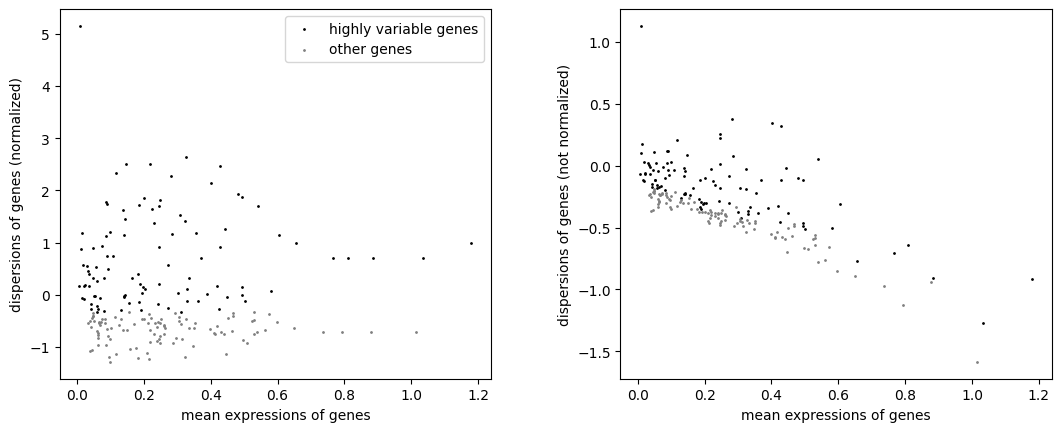

In [247]:
adata_subset = adata.copy()
sc.pp.log1p(adata_subset)
adata_subset = adata_subset[:, adata_subset.var.istf]
N_hvg = 100
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = False)
sc.pl.highly_variable_genes(adata_subset)
sc.pp.highly_variable_genes(adata_subset, n_top_genes = N_hvg, subset = True)

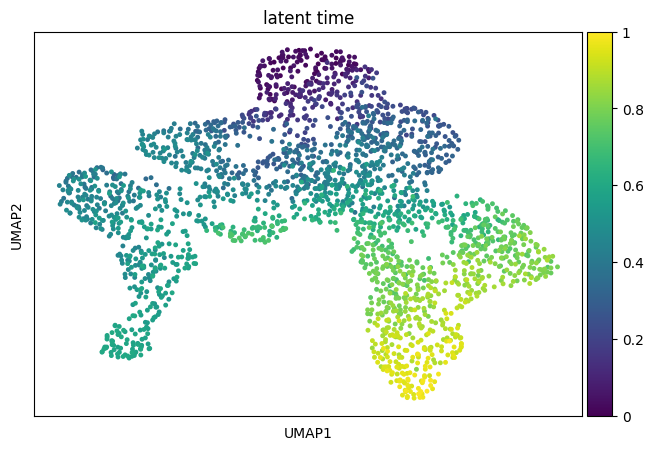

In [248]:
sc.pl.scatter(adata, basis = "umap", color = "latent_time")

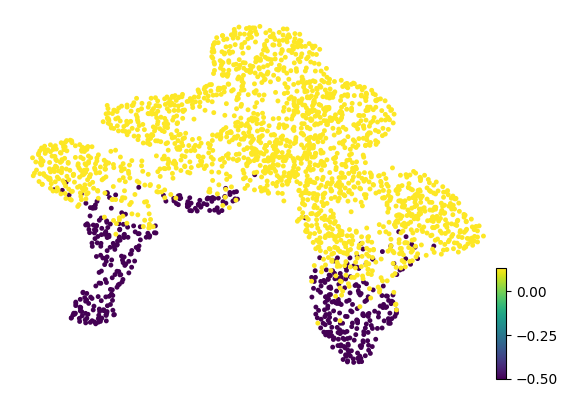

In [249]:
import statot
sink_idx = adata.obs.original_clusters.isin(["Myel. prog. #3", "Ery. prog. #2", "Eosinophil prog."])
R = np.zeros(adata.shape[0])
R[sink_idx] = -250/sum(sink_idx)
R[~sink_idx] = -R.sum()/sum(~sink_idx)
scv.pl.scatter(adata, color=R)

In [250]:
C = adata.obsm["C"]
gamma, mu, nu = statot.inference.statot(adata.obsm["X_pca"], g = np.exp(R), dt = 1, C = C, eps = 1.0*C.mean(), method = "quad")
adata.obsm["P_statot"] = statot.inference.row_normalise(gamma)

In [251]:
eps = 0.01
P = (1-eps)*adata.obsp["T_fwd"] + eps*sp.sparse.identity(adata.shape[0])

In [252]:
adata.write_h5ad(os.path.join(DATA_DIR, "anndata_unitvelo.h5ad"))
adata_subset.write_h5ad(os.path.join(DATA_DIR, "anndata_unitvelo_subset.h5ad"))
np.save(os.path.join(DATA_DIR, "X.npy"), adata_subset.X[:, adata_subset.var.istf].todense())
np.save(os.path.join(DATA_DIR, "X_pca.npy"), adata_subset.obsm["X_pca"])
np.save(os.path.join(DATA_DIR, "X_umap.npy"), adata_subset.obsm["X_umap"])
np.save(os.path.join(DATA_DIR, "dpt.npy"), adata_subset.obs.velocity_pseudotime)
np.save(os.path.join(DATA_DIR, "P.npy"), adata.obsp["T_fwd"].todense())
np.save(os.path.join(DATA_DIR, "P_statot.npy"), adata.obsm["P_statot"])
np.save(os.path.join(DATA_DIR, "R.npy"), adata.obsm["R"])
np.save(os.path.join(DATA_DIR, "C.npy"), adata.obsm["C"])

In [253]:
# run locaTE
!julia ../../tools/locaTE.jl/src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --suffix locate --gpu $DATA_DIR/X.npy $DATA_DIR/X_pca.npy $DATA_DIR/P.npy $DATA_DIR/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:41K
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
[ Info: ΔX = 4.457727453215555e-9, ΔZ = 7.846021023681649e-7, ΔW = 1.0266811795896225e-6
[ Info: tr(X'LX) = 5.991260922179308, 0.5|X-G|^2 = 7.703292554643649, |X|1 = 22385.90749302382


In [254]:
!julia ../../tools/locaTE.jl/src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --suffix locate_statot --gpu $DATA_DIR/X.npy $DATA_DIR/X_pca.npy $DATA_DIR/P_statot.npy $DATA_DIR/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:47K
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
[ Info: ΔX = 4.596099509994791e-9, ΔZ = 7.845527453011203e-7, ΔW = 1.0562676147039818e-6
[ Info: tr(X'LX) = 3.5655659645942217, 0.5|X-G|^2 = 6.209526274474502, |X|1 = 12075.452287529764


In [265]:
all(pd.read_csv(os.path.join("../../data/HSPC/UMAP_v_mean.csv"), index_col = 0).index == adata.obs.index)

True

In [266]:
!julia ../../tools/locaTE.jl/src/locaTE_cmd.jl --lambda1 10.0 --lambda2 0.001 --k_lap 25 --suffix locate_kappa --gpu $DATA_DIR/X.npy $DATA_DIR/X_pca.npy $DATA_DIR/P_kappavelo.npy $DATA_DIR/R.npy

[ Info: Reading input...
[ Info: Estimating TE scores...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:48K
[ Info: Denoising...
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
[ Info: ΔX = 4.705009319700934e-9, ΔZ = 6.457834612443036e-7, ΔW = 1.1131370007098906e-6
[ Info: tr(X'LX) = 5.103765780088262, 0.5|X-G|^2 = 6.878876836540475, |X|1 = 22314.36898585188
